# Importing Data

In [226]:
import pandas as pd

# Replace 'file_path' with the actual file path on your device
file_path = 'SD_OC_Data.csv'

# Load the CSV file into a pandas DataFrame
dfBeach = pd.read_csv(file_path)
dfBeach.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 241951 entries, 0 to 241950
Data columns (total 17 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            241951 non-null  int64  
 1   Station_ID    241951 non-null  int64  
 2   Station Name  241951 non-null  object 
 3   SampleDate    241951 non-null  object 
 4   SampleTime    241951 non-null  object 
 5   parameter     241951 non-null  object 
 6   qualifier     241941 non-null  object 
 7   Result        241951 non-null  float64
 8   unit          241951 non-null  object 
 9   method        241951 non-null  object 
 10  type          241951 non-null  object 
 11  County        241951 non-null  object 
 12  Description   239968 non-null  object 
 13  Beach Name    241951 non-null  object 
 14  Latitude      241849 non-null  float64
 15  Longitude     241849 non-null  float64
 16  CreateDate    241951 non-null  object 
dtypes: float64(3), int64(2), object(12)
memory usage

# Cleaning Data


#### Cleaning Data

<p>Removing Entries that do not follow the goal. Improper body of water or location.

In [227]:
!pip install folium --quiet

# Remove Non-Beach Entries
dfBeach = dfBeach[dfBeach['Description'] != 'Dairy Mart Bridge']
dfBeach= dfBeach[dfBeach['Description'] != 'Hollister Bridge']
dfBeach= dfBeach[dfBeach['Description'] != 'Blue Lagoon - Upcoast']
dfBeach= dfBeach[dfBeach['Description'] != 'Blue Lagoon - Downcoast']
dfBeach= dfBeach[dfBeach['Description'] != 'San Diego Crk @ Campus Dr']
dfBeach= dfBeach[dfBeach['Description'] != 'El Vigia MEX']
dfBeach= dfBeach[dfBeach['Description'] != 'Playas Blanca MEX']
dfBeach= dfBeach[dfBeach['Description'] != 'Playas De Tijuana MEX']

import folium
# Print unique values in the 'County' column for closer examination
unique_values = dfBeach['County'].unique()
print(unique_values)


['San Diego' 'Orange']


#### Cleaned Data Map

In [228]:
import folium
import pandas as pd
from folium.plugins import MarkerCluster

# Drop rows with NaN values in Latitude or Longitude
dfBeach_clean = dfBeach.dropna(subset=['Latitude', 'Longitude'])

# Create a map centered around California
my_map = folium.Map(location=[36.7783, -119.4179], zoom_start=6)

# Create a MarkerCluster layer
marker_cluster = MarkerCluster().add_to(my_map)

# Create a dictionary to store the most recent result for each description and parameter combination
most_recent_result = {}

for desc in dfBeach_clean['Description'].unique():
    filtered_df = dfBeach_clean[dfBeach_clean['Description'] == desc].sort_values('SampleDate', ascending=False)
    if not filtered_df.empty:
        for param in filtered_df['parameter'].unique():
            param_filtered_df = filtered_df[filtered_df['parameter'] == param]
            most_recent_result[(desc, param)] = param_filtered_df.iloc[0]

# Add markers for each Latitude and Longitude point, with popups showing the most recent result for each parameter
for (desc, param), row in most_recent_result.items():
    popup_text = f"Description: {desc}<br>Parameter: {param}<br>Most Recent Result: {row['Result']:.2f}"
    folium.Marker([row['Latitude'], row['Longitude']], popup=popup_text).add_to(marker_cluster)

# Display the map
my_map


# Observing Data

#### Medians and Means of Data with and without Extraneous Values

In [229]:
from scipy import stats

# Calculate the z-scores for 'Result' within each 'parameter' group
dfBeach['z_score'] = dfBeach.groupby('parameter')['Result'].transform(lambda x: (x - x.mean()) / x.std())

# Exclude rows where the absolute z-score is greater than 3 (considered as outliers)
dfBeach_no_outliers = dfBeach[dfBeach['z_score'].abs() <= 3]

# Calculate the average 'Result' for each 'parameter' after excluding outliers
average_results_no_outliers = dfBeach_no_outliers.groupby('parameter')['Result'].mean()
print("No Extraneous Values")
print(average_results_no_outliers)
print()
print('Normal Averages')
average_results = dfBeach.groupby('parameter')['Result'].mean()
print(average_results)

# Calculate the median 'Result' for each 'parameter' after excluding outliers
median_results_no_outliers = dfBeach_no_outliers.groupby('parameter')['Result'].median()
print("Median (No Extraneous Values):")
print(median_results_no_outliers)
print()

# Calculate the median 'Result' for each 'parameter' without excluding outliers
median_results = dfBeach.groupby('parameter')['Result'].median()
print("Median (Including Extraneous Values):")
print(median_results)




No Extraneous Values
parameter
E. Coli              94.623215
Enterococcus       1565.698307
Fecal Coliforms     105.406228
Total Coliforms     664.698049
Name: Result, dtype: float64

Normal Averages
parameter
E. Coli             240.538109
Enterococcus       4725.822008
Fecal Coliforms     247.858451
Total Coliforms    1055.692934
Name: Result, dtype: float64
Median (No Extraneous Values):
parameter
E. Coli            10.0
Enterococcus       10.0
Fecal Coliforms    10.0
Total Coliforms    20.0
Name: Result, dtype: float64

Median (Including Extraneous Values):
parameter
E. Coli            10.0
Enterococcus       10.0
Fecal Coliforms    10.0
Total Coliforms    20.0
Name: Result, dtype: float64


#### Parameter (Report) Types

In [230]:
# Displaying the unique entries for the "parameter" column
unique_parameters = dfBeach['parameter'].unique()
print(unique_parameters)

['Enterococcus' 'Total Coliforms' 'E. Coli' 'Fecal Coliforms']


#### Locations with Highest Count of Each Report

In [231]:
# Group by 'parameter' and find the row with the highest 'Result' for each 'parameter'
max_result_indices = dfBeach.groupby('parameter')['Result'].idxmax()

# Use the indices to retrieve the corresponding rows and print the 'Description' and 'Result' for each 'parameter'
for idx in max_result_indices:
    row = dfBeach.loc[idx]
    print(f"Parameter: {row['parameter']}, Description with Highest Result: {row['Description']}, Highest Result: {row['Result']}")

Parameter: E. Coli, Description with Highest Result: End of Seacoast Dr, Highest Result: 24196.0
Parameter: Enterococcus, Description with Highest Result: Tijuana Estuary mouth, Highest Result: 4000000.0
Parameter: Fecal Coliforms, Description with Highest Result: Cottonwood Creek outlet, Highest Result: 398000.0
Parameter: Total Coliforms, Description with Highest Result: Seascape near outlet, Highest Result: 5000000.0


#### Top Location for Each Parameter (For Each Year)

In [232]:
# Convert 'SampleDate' to datetime
dfBeach['SampleDate'] = pd.to_datetime(dfBeach['SampleDate'])

# Filter the DataFrame for the specified years
years = [2002, 2019, 2020, 2021, 2022, 2023, 2024]
df_filtered = dfBeach[dfBeach['SampleDate'].dt.year.isin(years)]

# Group by 'parameter' and year, and find the row with the highest 'Result' for each group
max_result_indices = df_filtered.groupby(['parameter', df_filtered['SampleDate'].dt.year])['Result'].idxmax()

# Use the indices to retrieve the corresponding rows and print the 'Description' and 'Result' for each 'parameter' for each year
for idx in max_result_indices:
    row = df_filtered.loc[idx]
    print(f"Year: {row['SampleDate'].year}, Parameter: {row['parameter']}, Description with Highest Result: {row['Description']}, Highest Result: {row['Result']}")


Year: 2002, Parameter: E. Coli, Description with Highest Result: San Diego River outlet, Highest Result: 4786.0
Year: 2019, Parameter: E. Coli, Description with Highest Result: Tidelands Park, Highest Result: 24196.0
Year: 2020, Parameter: E. Coli, Description with Highest Result: Tijuana Estuary mouth, Highest Result: 24196.0
Year: 2021, Parameter: E. Coli, Description with Highest Result: End of Seacoast Dr, Highest Result: 24196.0
Year: 2022, Parameter: E. Coli, Description with Highest Result: Carnation Ave., Highest Result: 24196.0
Year: 2023, Parameter: E. Coli, Description with Highest Result: Tidelands Park, Highest Result: 3654.0
Year: 2024, Parameter: E. Coli, Description with Highest Result: Tidelands Park, Highest Result: 327.0
Year: 2002, Parameter: Enterococcus, Description with Highest Result: 15th St. near outlet, Highest Result: 1445000.0
Year: 2019, Parameter: Enterococcus, Description with Highest Result: North Beach - Zero Point, Highest Result: 40000.0
Year: 2020, 

# Map of Top Pollutant Spots

In [233]:
import folium
from folium.plugins import MarkerCluster
from datetime import datetime

# Define a color palette for different years
color_palette = {
    2002: 'cadetblue',
    2019: 'blue', 
    2020: 'green',
    2021: 'darkgreen',
    2022: 'pink',
    2023: 'orange',
    2024: 'red',
    # Add more years and colors as needed
}

# Create a map centered around California
my_map = folium.Map(location=[36.7783, -119.4179], zoom_start=6)

# Create a MarkerCluster object
marker_cluster = MarkerCluster().add_to(my_map)

color_legend = """
    <div style="position: fixed; 
                top: 10px; left: 10px; width: 120px; height: auto; 
                border:2px solid grey; z-index:9999; font-size:14px;
                background-color:white;
                opacity: 0.7;
                ">
      <p style="margin:5px">Color Legend</p>
      <p style="margin:5px"><i class="fa fa-square" style="color:cadetblue"></i> 2002</p>
      <p style="margin:5px"><i class="fa fa-square" style="color:blue"></i> 2019</p>
      <p style="margin:5px"><i class="fa fa-square" style="color:green"></i> 2020</p>
      <p style="margin:5px"><i class="fa fa-square" style="color:darkgreen"></i> 2021</p>
      <p style="margin:5px"><i class="fa fa-square" style="color:pink"></i> 2022</p>
      <p style="margin:5px"><i class="fa fa-square" style="color:orange"></i> 2023</p>
      <p style="margin:5px"><i class="fa fa-square" style="color:red"></i> 2024</p>
    </div>
    """

# Add the color legend to the map
my_map.get_root().html.add_child(folium.Element(color_legend))

# Use the indices to retrieve the corresponding rows and add markers to the map
for idx in max_result_indices:
    row = df_filtered.loc[idx]
    parameter = row['parameter']
    sample_date = row['SampleDate']
    
    # Extract year from SampleDate
    year = sample_date.year
    
    # Determine marker color based on year
    if year in color_palette:
        marker_color = color_palette[year]
    else:
        marker_color = 'gray'  # Default color if year not found in color_palette
    
    # Use icons based on parameter
    if parameter == 'E. Coli':
        icon = folium.Icon(color=marker_color, icon='bacterium', prefix='fa')  # Using Font Awesome icon
    elif parameter == 'Enterococcus':
        icon = folium.Icon(color=marker_color, icon='disease', prefix='fa')  # Using Font Awesome icon
    elif parameter == 'Fecal Coliforms':
        icon = folium.Icon(color=marker_color, icon='poop', prefix='fa')  # Using Font Awesome icon
    elif parameter == 'Total Coliforms':
        icon = folium.Icon(color=marker_color, icon='tint', prefix='fa')  # Using Font Awesome icon
    else:
        icon = folium.Icon(color=marker_color, icon='info-sign', prefix='glyphicon')  # Using Bootstrap Glyphicon icon
    
    popup_text = f"Year: {year}<br>Parameter: {parameter}<br>Description with Highest Result: {row['Description']}"
    popup_text += f"<br>Highest Result: {row['Result']}"
    
    marker = folium.Marker([row['Latitude'], row['Longitude']], popup=popup_text, icon=icon)
    marker.add_to(marker_cluster)  # Add marker to the MarkerCluster

# Display the map
my_map


# Reports Over Time

#### Total Coliforms

C:\Users\Grant\AppData\Local\Temp\ipykernel_4740\2729525281.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



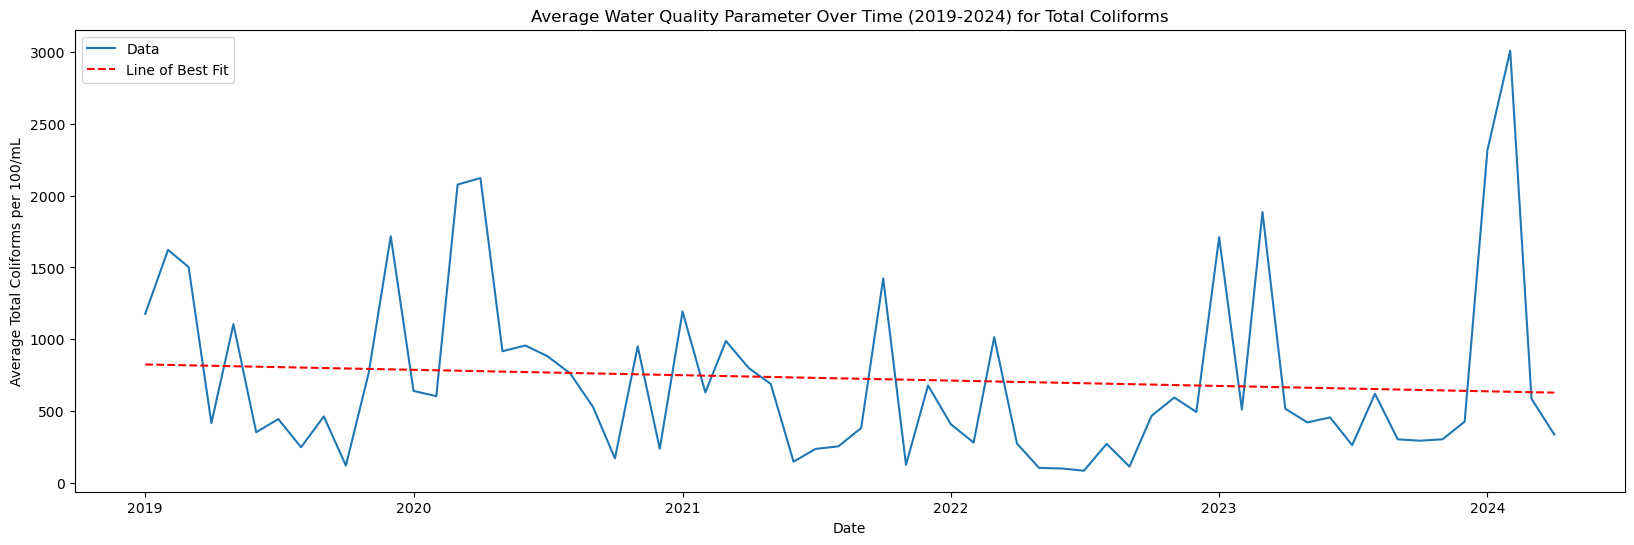

In [234]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Assuming dfBeach is your DataFrame
dfBeach['SampleDate'] = pd.to_datetime(dfBeach['SampleDate'])

# Filter the DataFrame for years greater than or equal to 2018 and parameter equal to 'Total Coliforms'
df_filtered = dfBeach[(dfBeach['SampleDate'].dt.year >= 2018) & 
                      (dfBeach['parameter'] == 'Total Coliforms') &
                      (dfBeach['SampleDate'].dt.year <= 2024) &  
                      (dfBeach['Result'] < 400000)]

# Calculate the average monthly result
df_filtered['YearMonth'] = df_filtered['SampleDate'].dt.to_period('M')
monthly_avg = df_filtered.groupby('YearMonth')['Result'].mean()

# Plot the data
plt.figure(figsize=(20, 6))
plt.plot(monthly_avg.index.to_timestamp(), monthly_avg.values, label='Data')
plt.xlabel('Date')
plt.ylabel('Average Total Coliforms per 100/mL')
plt.title('Average Water Quality Parameter Over Time (2019-2024) for Total Coliforms')

# Add a line of best fit
x = monthly_avg.index.to_timestamp().values.astype(np.int64) // 10 ** 9  # Convert to Unix timestamp
y = monthly_avg.values
z = np.polyfit(x, y, 1)  # Fit a first-degree polynomial
p = np.poly1d(z)
plt.plot(monthly_avg.index.to_timestamp(), p(x), 'r--', label='Line of Best Fit')

plt.legend()
plt.show()


#### E Coli

C:\Users\Grant\AppData\Local\Temp\ipykernel_4740\1002194076.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



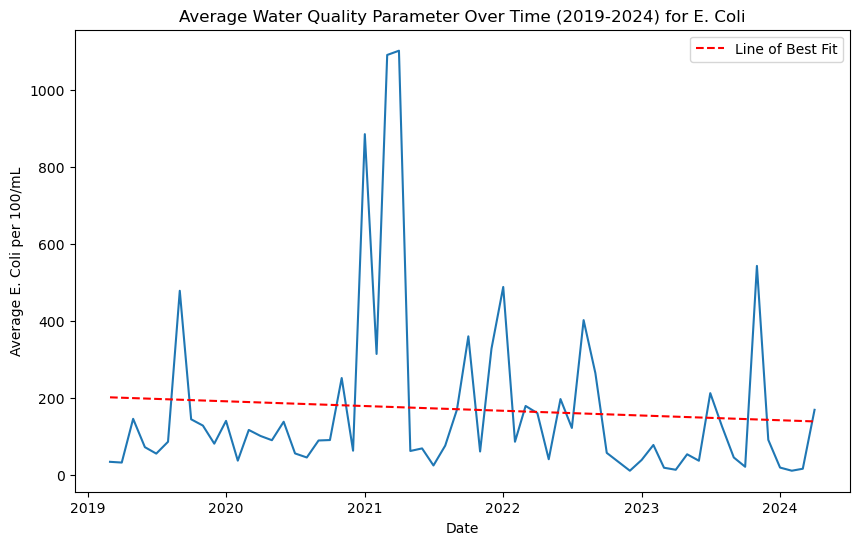

In [235]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming dfBeach is your DataFrame
dfBeach['SampleDate'] = pd.to_datetime(dfBeach['SampleDate'])

# Filter the DataFrame for years greater than or equal to 2018 and parameter equal to 'E. Coli'
df_filtered = dfBeach[(dfBeach['SampleDate'].dt.year >= 2018) & (dfBeach['parameter'] == 'E. Coli')]

# Calculate the average monthly result
df_filtered['YearMonth'] = df_filtered['SampleDate'].dt.to_period('M')
monthly_avg = df_filtered.groupby('YearMonth')['Result'].mean()

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(monthly_avg.index.to_timestamp(), monthly_avg.values)
plt.xlabel('Date')
plt.ylabel('Average E. Coli per 100/mL')
plt.title('Average Water Quality Parameter Over Time (2019-2024) for E. Coli')
# Add a line of best fit
x = monthly_avg.index.to_timestamp().values.astype(np.int64) // 10 ** 9  # Convert to Unix timestamp
y = monthly_avg.values
z = np.polyfit(x, y, 1)  # Fit a first-degree polynomial
p = np.poly1d(z)
plt.plot(monthly_avg.index.to_timestamp(), p(x), 'r--', label='Line of Best Fit')

plt.legend()
plt.show()


#### Fecal Coliforms

C:\Users\Grant\AppData\Local\Temp\ipykernel_4740\4059060953.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



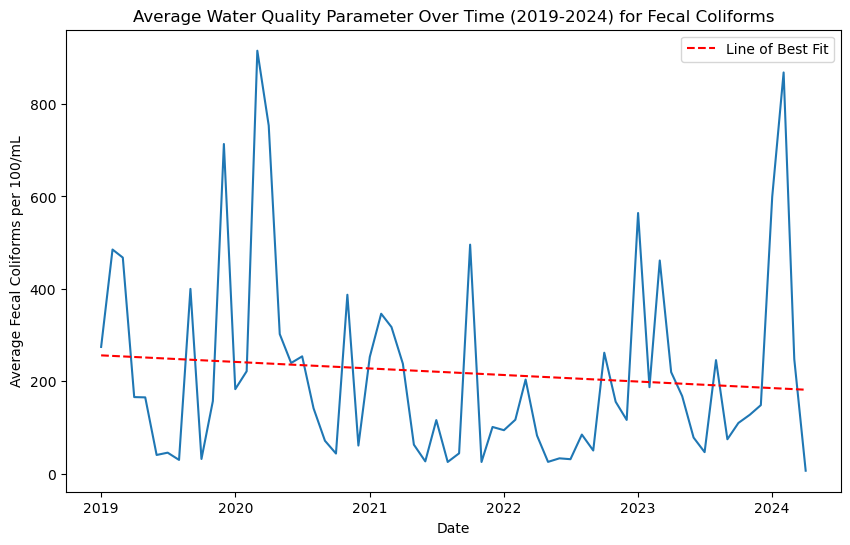

In [236]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming dfBeach is your DataFrame
dfBeach['SampleDate'] = pd.to_datetime(dfBeach['SampleDate'])

# Filter the DataFrame for years greater than or equal to 2018 and parameter equal to 'Fecal Coliforms'
df_filtered = dfBeach[(dfBeach['SampleDate'].dt.year >= 2018) & (dfBeach['parameter'] == 'Fecal Coliforms')]

# Calculate the average monthly result
df_filtered['YearMonth'] = df_filtered['SampleDate'].dt.to_period('M')
monthly_avg = df_filtered.groupby('YearMonth')['Result'].mean()

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(monthly_avg.index.to_timestamp(), monthly_avg.values)
plt.xlabel('Date')
plt.ylabel('Average Fecal Coliforms per 100/mL')
plt.title('Average Water Quality Parameter Over Time (2019-2024) for Fecal Coliforms')
# Add a line of best fit
x = monthly_avg.index.to_timestamp().values.astype(np.int64) // 10 ** 9  # Convert to Unix timestamp
y = monthly_avg.values
z = np.polyfit(x, y, 1)  # Fit a first-degree polynomial
p = np.poly1d(z)
plt.plot(monthly_avg.index.to_timestamp(), p(x), 'r--', label='Line of Best Fit')

plt.legend()
plt.show()


#### Enterococcus

C:\Users\Grant\AppData\Local\Temp\ipykernel_4740\3986787619.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



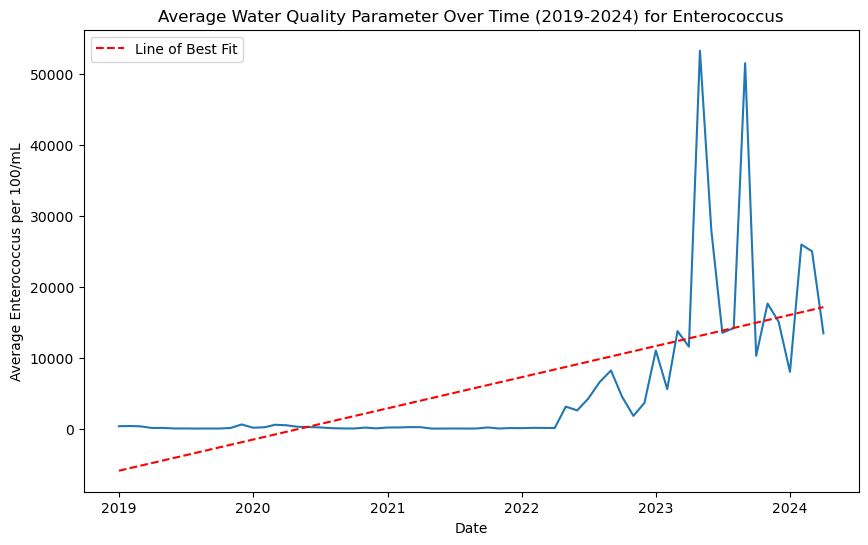

In [237]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming dfBeach is your DataFrame
dfBeach['SampleDate'] = pd.to_datetime(dfBeach['SampleDate'])

# Filter the DataFrame for years greater than or equal to 2018 and parameter equal to 'Enterococcus'
df_filtered = dfBeach[(dfBeach['SampleDate'].dt.year >= 2018) & (dfBeach['parameter'] == 'Enterococcus')]

# Calculate the average monthly result
df_filtered['YearMonth'] = df_filtered['SampleDate'].dt.to_period('M')
monthly_avg = df_filtered.groupby('YearMonth')['Result'].mean()

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(monthly_avg.index.to_timestamp(), monthly_avg.values)
plt.xlabel('Date')
plt.ylabel('Average Enterococcus per 100/mL')
plt.title('Average Water Quality Parameter Over Time (2019-2024) for Enterococcus')
# Add a line of best fit
x = monthly_avg.index.to_timestamp().values.astype(np.int64) // 10 ** 9  # Convert to Unix timestamp
y = monthly_avg.values
z = np.polyfit(x, y, 1)  # Fit a first-degree polynomial
p = np.poly1d(z)
plt.plot(monthly_avg.index.to_timestamp(), p(x), 'r--', label='Line of Best Fit')

plt.legend()
plt.show()


# OC Reports Over Time

#### OC Total

C:\Users\Grant\AppData\Local\Temp\ipykernel_4740\2676194636.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



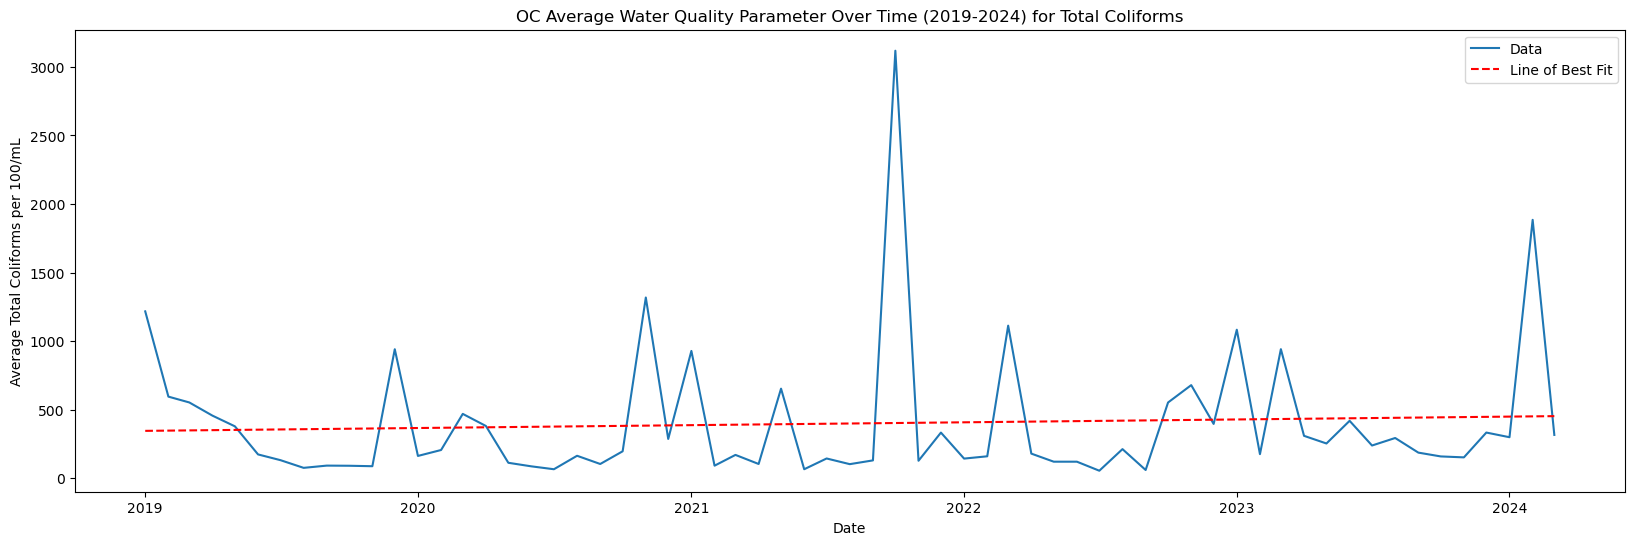

In [238]:
# Reports Over Time Orange County
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Assuming dfBeach is your DataFrame
dfBeach['SampleDate'] = pd.to_datetime(dfBeach['SampleDate'])

# Filter the DataFrame for years greater than or equal to 2018 and parameter equal to 'Total Coliforms'
df_filtered = dfBeach[(dfBeach['SampleDate'].dt.year >= 2018) & 
                      (dfBeach['parameter'] == 'Total Coliforms') &
                      (dfBeach['County'] == 'Orange') & 
                      (dfBeach['Result'] < 400000)]

# Calculate the average monthly result
df_filtered['YearMonth'] = df_filtered['SampleDate'].dt.to_period('M')
monthly_avg = df_filtered.groupby('YearMonth')['Result'].mean()

# Plot the data
plt.figure(figsize=(20, 6))
plt.plot(monthly_avg.index.to_timestamp(), monthly_avg.values, label='Data')
plt.xlabel('Date')
plt.ylabel('Average Total Coliforms per 100/mL')
plt.title('OC Average Water Quality Parameter Over Time (2019-2024) for Total Coliforms')

# Add a line of best fit
x = monthly_avg.index.to_timestamp().values.astype(np.int64) // 10 ** 9  # Convert to Unix timestamp
y = monthly_avg.values
z = np.polyfit(x, y, 1)  # Fit a first-degree polynomial
p = np.poly1d(z)
plt.plot(monthly_avg.index.to_timestamp(), p(x), 'r--', label='Line of Best Fit')

plt.legend()
plt.show()


#### OC Enterococcus


C:\Users\Grant\AppData\Local\Temp\ipykernel_4740\1718399499.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



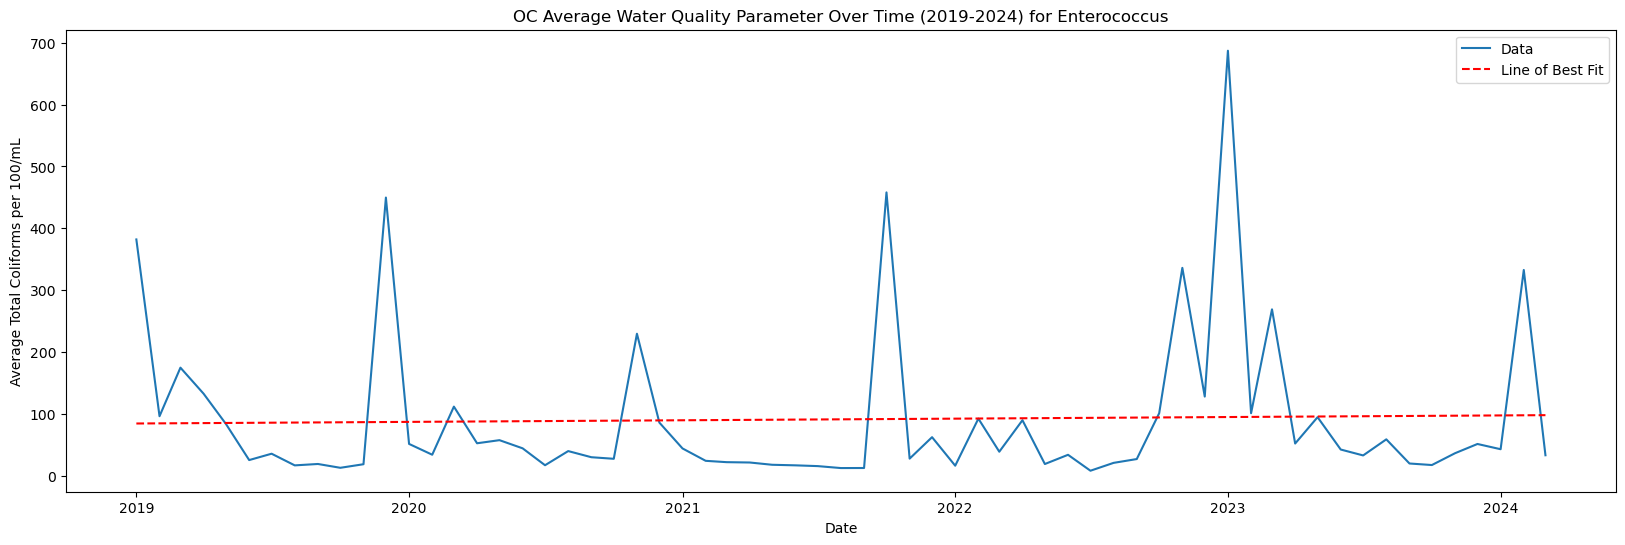

In [239]:
# Reports Over Time Orange County
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Assuming dfBeach is your DataFrame
dfBeach['SampleDate'] = pd.to_datetime(dfBeach['SampleDate'])

# Filter the DataFrame for years greater than or equal to 2018 and parameter equal to 'Total Coliforms'
df_filtered = dfBeach[(dfBeach['SampleDate'].dt.year >= 2018) & 
                      (dfBeach['parameter'] == 'Enterococcus') &
                      (dfBeach['County'] == 'Orange') & 
                      (dfBeach['Result'] < 400000)]

# Calculate the average monthly result
df_filtered['YearMonth'] = df_filtered['SampleDate'].dt.to_period('M')
monthly_avg = df_filtered.groupby('YearMonth')['Result'].mean()

# Plot the data
plt.figure(figsize=(20, 6))
plt.plot(monthly_avg.index.to_timestamp(), monthly_avg.values, label='Data')
plt.xlabel('Date')
plt.ylabel('Average Total Coliforms per 100/mL')
plt.title('OC Average Water Quality Parameter Over Time (2019-2024) for Enterococcus')

# Add a line of best fit
x = monthly_avg.index.to_timestamp().values.astype(np.int64) // 10 ** 9  # Convert to Unix timestamp
y = monthly_avg.values
z = np.polyfit(x, y, 1)  # Fit a first-degree polynomial
p = np.poly1d(z)
plt.plot(monthly_avg.index.to_timestamp(), p(x), 'r--', label='Line of Best Fit')

plt.legend()
plt.show()

#### OC Fecal Coliforms

C:\Users\Grant\AppData\Local\Temp\ipykernel_4740\987919489.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



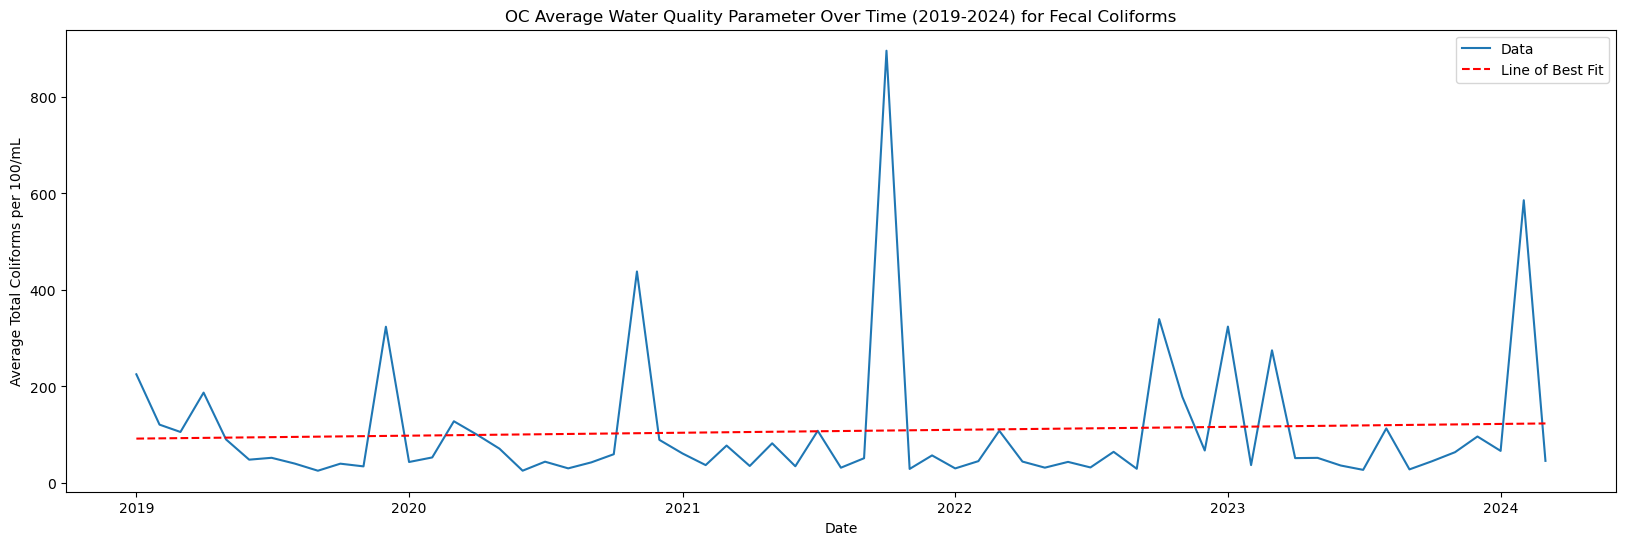

In [240]:
# Reports Over Time Orange County
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Assuming dfBeach is your DataFrame
dfBeach['SampleDate'] = pd.to_datetime(dfBeach['SampleDate'])

# Filter the DataFrame for years greater than or equal to 2018 and parameter equal to 'Total Coliforms'
df_filtered = dfBeach[(dfBeach['SampleDate'].dt.year >= 2018) & 
                      (dfBeach['parameter'] == 'Fecal Coliforms') &
                      (dfBeach['County'] == 'Orange') & 
                      (dfBeach['Result'] < 400000)]

# Calculate the average monthly result
df_filtered['YearMonth'] = df_filtered['SampleDate'].dt.to_period('M')
monthly_avg = df_filtered.groupby('YearMonth')['Result'].mean()

# Plot the data
plt.figure(figsize=(20, 6))
plt.plot(monthly_avg.index.to_timestamp(), monthly_avg.values, label='Data')
plt.xlabel('Date')
plt.ylabel('Average Total Coliforms per 100/mL')
plt.title('OC Average Water Quality Parameter Over Time (2019-2024) for Fecal Coliforms')

# Add a line of best fit
x = monthly_avg.index.to_timestamp().values.astype(np.int64) // 10 ** 9  # Convert to Unix timestamp
y = monthly_avg.values
z = np.polyfit(x, y, 1)  # Fit a first-degree polynomial
p = np.poly1d(z)
plt.plot(monthly_avg.index.to_timestamp(), p(x), 'r--', label='Line of Best Fit')

plt.legend()
plt.show()

# SD Monthly Report

#### SD Total

C:\Users\Grant\AppData\Local\Temp\ipykernel_4740\134114868.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



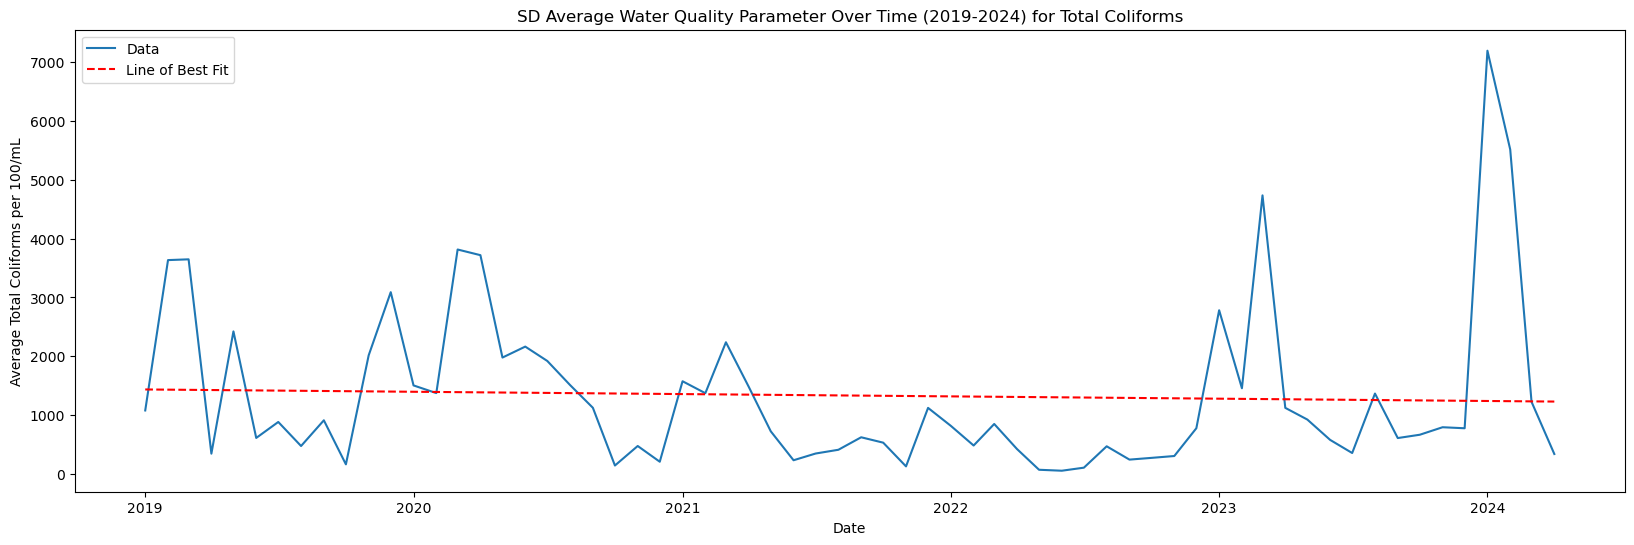

In [241]:
# Reports Over Time Orange County
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Assuming dfBeach is your DataFrame
dfBeach['SampleDate'] = pd.to_datetime(dfBeach['SampleDate'])

# Filter the DataFrame for years greater than or equal to 2018 and parameter equal to 'Total Coliforms'
df_filtered = dfBeach[(dfBeach['SampleDate'].dt.year >= 2018) & 
                      (dfBeach['parameter'] == 'Total Coliforms') &
                      (dfBeach['County'] == 'San Diego') & 
                      (dfBeach['Result'] < 400000)]

# Calculate the average monthly result
df_filtered['YearMonth'] = df_filtered['SampleDate'].dt.to_period('M')
monthly_avg = df_filtered.groupby('YearMonth')['Result'].mean()

# Plot the data
plt.figure(figsize=(20, 6))
plt.plot(monthly_avg.index.to_timestamp(), monthly_avg.values, label='Data')
plt.xlabel('Date')
plt.ylabel('Average Total Coliforms per 100/mL')
plt.title('SD Average Water Quality Parameter Over Time (2019-2024) for Total Coliforms')

# Add a line of best fit
x = monthly_avg.index.to_timestamp().values.astype(np.int64) // 10 ** 9  # Convert to Unix timestamp
y = monthly_avg.values
z = np.polyfit(x, y, 1)  # Fit a first-degree polynomial
p = np.poly1d(z)
plt.plot(monthly_avg.index.to_timestamp(), p(x), 'r--', label='Line of Best Fit')

plt.legend()
plt.show()


#### SD E Coli

C:\Users\Grant\AppData\Local\Temp\ipykernel_4740\2334803389.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



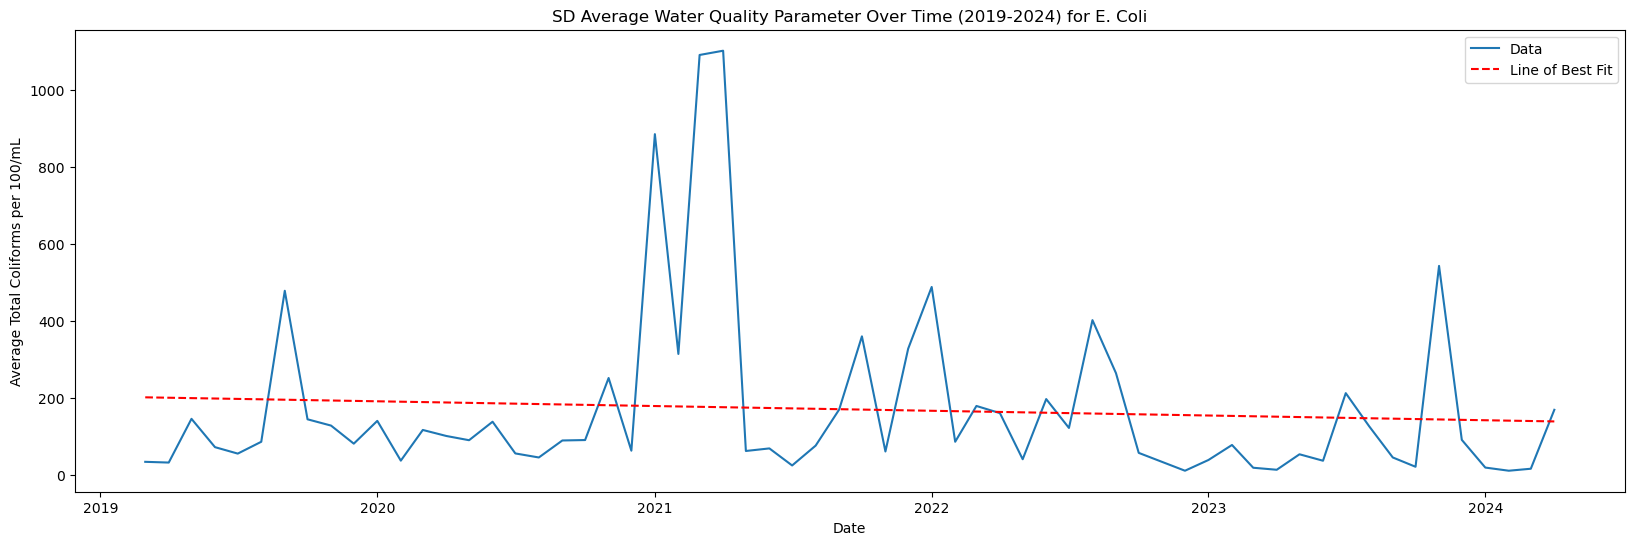

In [242]:
# Reports Over Time Orange County
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Assuming dfBeach is your DataFrame
dfBeach['SampleDate'] = pd.to_datetime(dfBeach['SampleDate'])

# Filter the DataFrame for years greater than or equal to 2018 and parameter equal to 'Total Coliforms'
df_filtered = dfBeach[(dfBeach['SampleDate'].dt.year >= 2018) & 
                      (dfBeach['parameter'] == 'E. Coli') &
                      (dfBeach['County'] == 'San Diego') & 
                      (dfBeach['Result'] < 400000)]

# Calculate the average monthly result
df_filtered['YearMonth'] = df_filtered['SampleDate'].dt.to_period('M')
monthly_avg = df_filtered.groupby('YearMonth')['Result'].mean()

# Plot the data
plt.figure(figsize=(20, 6))
plt.plot(monthly_avg.index.to_timestamp(), monthly_avg.values, label='Data')
plt.xlabel('Date')
plt.ylabel('Average Total Coliforms per 100/mL')
plt.title('SD Average Water Quality Parameter Over Time (2019-2024) for E. Coli')

# Add a line of best fit
x = monthly_avg.index.to_timestamp().values.astype(np.int64) // 10 ** 9  # Convert to Unix timestamp
y = monthly_avg.values
z = np.polyfit(x, y, 1)  # Fit a first-degree polynomial
p = np.poly1d(z)
plt.plot(monthly_avg.index.to_timestamp(), p(x), 'r--', label='Line of Best Fit')

plt.legend()
plt.show()


#### SD Enterococcus

C:\Users\Grant\AppData\Local\Temp\ipykernel_4740\3527569257.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



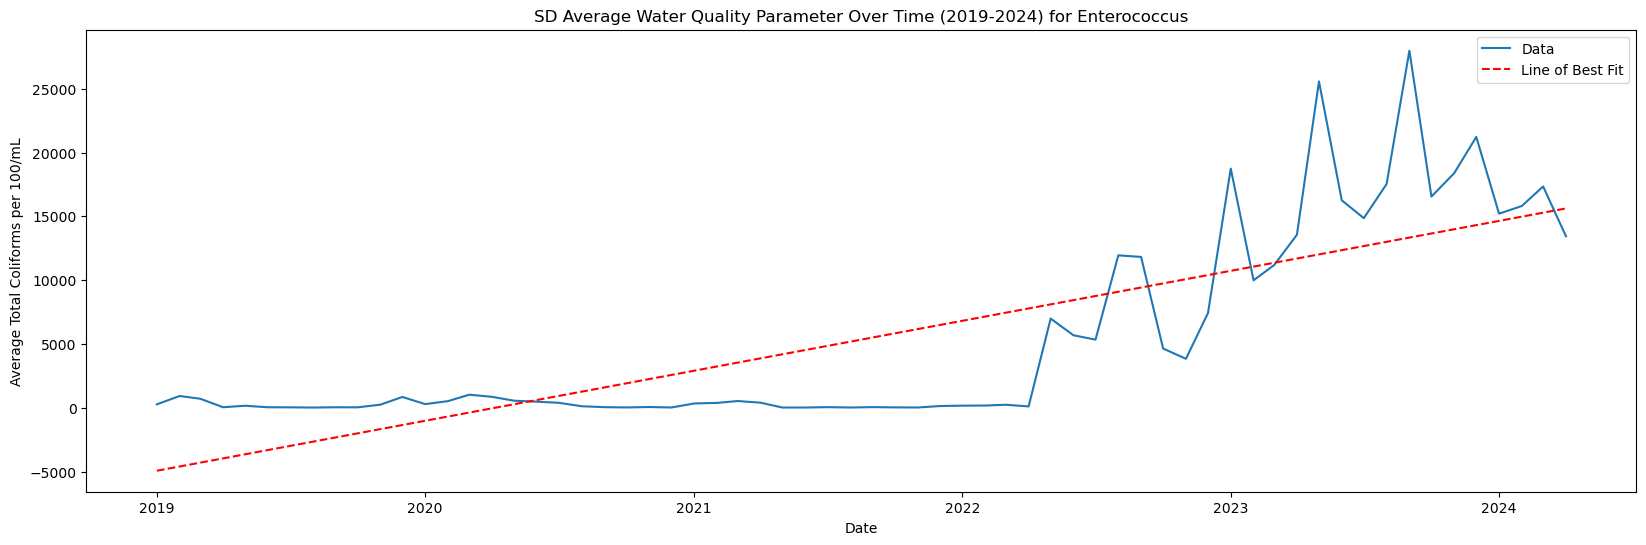

In [243]:
# Reports Over Time Orange County
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Assuming dfBeach is your DataFrame
dfBeach['SampleDate'] = pd.to_datetime(dfBeach['SampleDate'])

# Filter the DataFrame for years greater than or equal to 2018 and parameter equal to 'Total Coliforms'
df_filtered = dfBeach[(dfBeach['SampleDate'].dt.year >= 2018) & 
                      (dfBeach['parameter'] == 'Enterococcus') &
                      (dfBeach['County'] == 'San Diego') & 
                      (dfBeach['Result'] < 400000)]

# Calculate the average monthly result
df_filtered['YearMonth'] = df_filtered['SampleDate'].dt.to_period('M')
monthly_avg = df_filtered.groupby('YearMonth')['Result'].mean()

# Plot the data
plt.figure(figsize=(20, 6))
plt.plot(monthly_avg.index.to_timestamp(), monthly_avg.values, label='Data')
plt.xlabel('Date')
plt.ylabel('Average Total Coliforms per 100/mL')
plt.title('SD Average Water Quality Parameter Over Time (2019-2024) for Enterococcus')

# Add a line of best fit
x = monthly_avg.index.to_timestamp().values.astype(np.int64) // 10 ** 9  # Convert to Unix timestamp
y = monthly_avg.values
z = np.polyfit(x, y, 1)  # Fit a first-degree polynomial
p = np.poly1d(z)
plt.plot(monthly_avg.index.to_timestamp(), p(x), 'r--', label='Line of Best Fit')

plt.legend()
plt.show()


#### SD Fecal Coliforms

C:\Users\Grant\AppData\Local\Temp\ipykernel_4740\3465892801.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



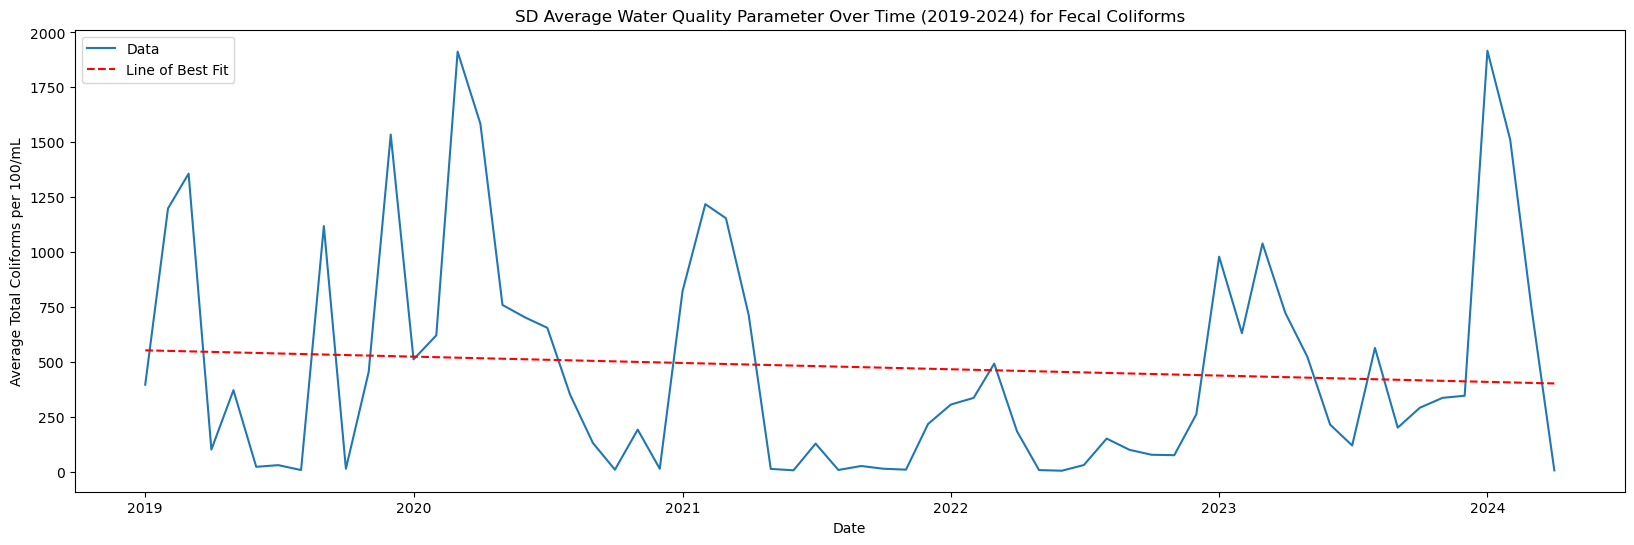

In [244]:
# Reports Over Time Orange County
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Assuming dfBeach is your DataFrame
dfBeach['SampleDate'] = pd.to_datetime(dfBeach['SampleDate'])

# Filter the DataFrame for years greater than or equal to 2018 and parameter equal to 'Total Coliforms'
df_filtered = dfBeach[(dfBeach['SampleDate'].dt.year >= 2018) & 
                      (dfBeach['parameter'] == 'Fecal Coliforms') &
                      (dfBeach['County'] == 'San Diego') & 
                      (dfBeach['Result'] < 400000)]

# Calculate the average monthly result
df_filtered['YearMonth'] = df_filtered['SampleDate'].dt.to_period('M')
monthly_avg = df_filtered.groupby('YearMonth')['Result'].mean()

# Plot the data
plt.figure(figsize=(20, 6))
plt.plot(monthly_avg.index.to_timestamp(), monthly_avg.values, label='Data')
plt.xlabel('Date')
plt.ylabel('Average Total Coliforms per 100/mL')
plt.title('SD Average Water Quality Parameter Over Time (2019-2024) for Fecal Coliforms')

# Add a line of best fit
x = monthly_avg.index.to_timestamp().values.astype(np.int64) // 10 ** 9  # Convert to Unix timestamp
y = monthly_avg.values
z = np.polyfit(x, y, 1)  # Fit a first-degree polynomial
p = np.poly1d(z)
plt.plot(monthly_avg.index.to_timestamp(), p(x), 'r--', label='Line of Best Fit')

plt.legend()
plt.show()


# Monthly Average Report Graphs

#### Average Monthly Extraneous

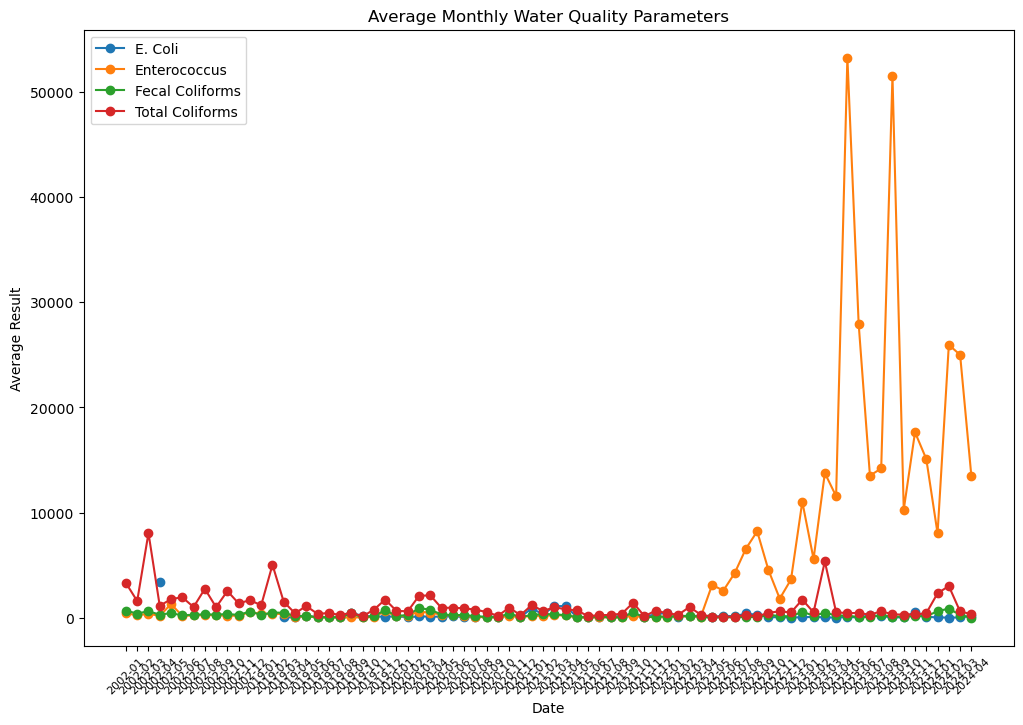

In [245]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming dfBeach is your DataFrame
dfBeach['SampleDate'] = pd.to_datetime(dfBeach['SampleDate'])

# Calculate the average monthly result for each parameter
dfBeach['Month'] = dfBeach['SampleDate'].dt.to_period('M')
monthly_avg = dfBeach.groupby(['Month', 'parameter'])['Result'].mean().unstack()

# Convert Period index to string
monthly_avg.index = monthly_avg.index.strftime('%Y-%m')

# Plot the data
plt.figure(figsize=(12, 8))
for column in monthly_avg.columns:
    plt.plot(monthly_avg.index, monthly_avg[column], marker='o', linestyle='-', label=column)

plt.xlabel('Date')
plt.ylabel('Average Result')
plt.title('Average Monthly Water Quality Parameters')
plt.legend()
plt.xticks(rotation=45, fontsize=8)  # Set the font size for x-axis labels
plt.show()

#### Average Monthly Non Extraneous

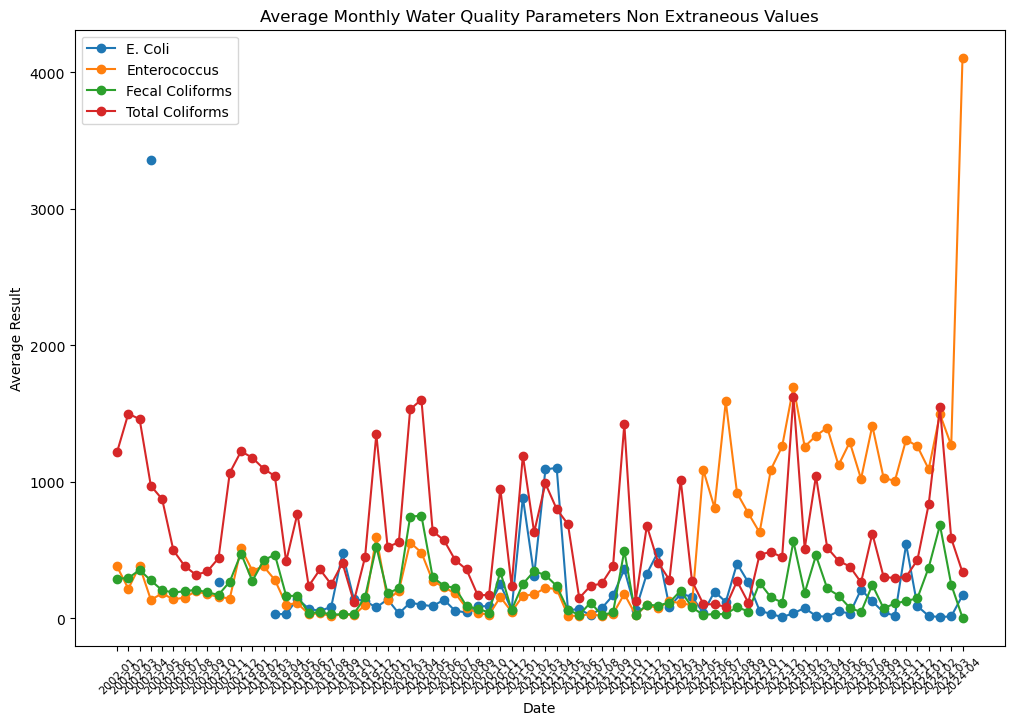

In [246]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming dfBeach is your DataFrame
dfBeach['SampleDate'] = pd.to_datetime(dfBeach['SampleDate'])

# Remove extraneous values (for example, filtering based on a condition)
dfBeach = dfBeach[dfBeach['Result'] < 30000]  # Replace with your specific condition

# Calculate the average monthly result for each parameter
dfBeach['Month'] = dfBeach['SampleDate'].dt.to_period('M')
monthly_avg = dfBeach.groupby(['Month', 'parameter'])['Result'].mean().unstack()

# Convert Period index to string
monthly_avg.index = monthly_avg.index.strftime('%Y-%m')

# Plot the data
plt.figure(figsize=(12, 8))
for column in monthly_avg.columns:
    plt.plot(monthly_avg.index, monthly_avg[column], marker='o', linestyle='-', label=column)

plt.xlabel('Date')
plt.ylabel('Average Result')
plt.title('Average Monthly Water Quality Parameters Non Extraneous Values')
plt.legend()
plt.xticks(rotation=45, fontsize=8)  # Set the font size for x-axis labels
plt.show()

#### Average Monthly Orange County

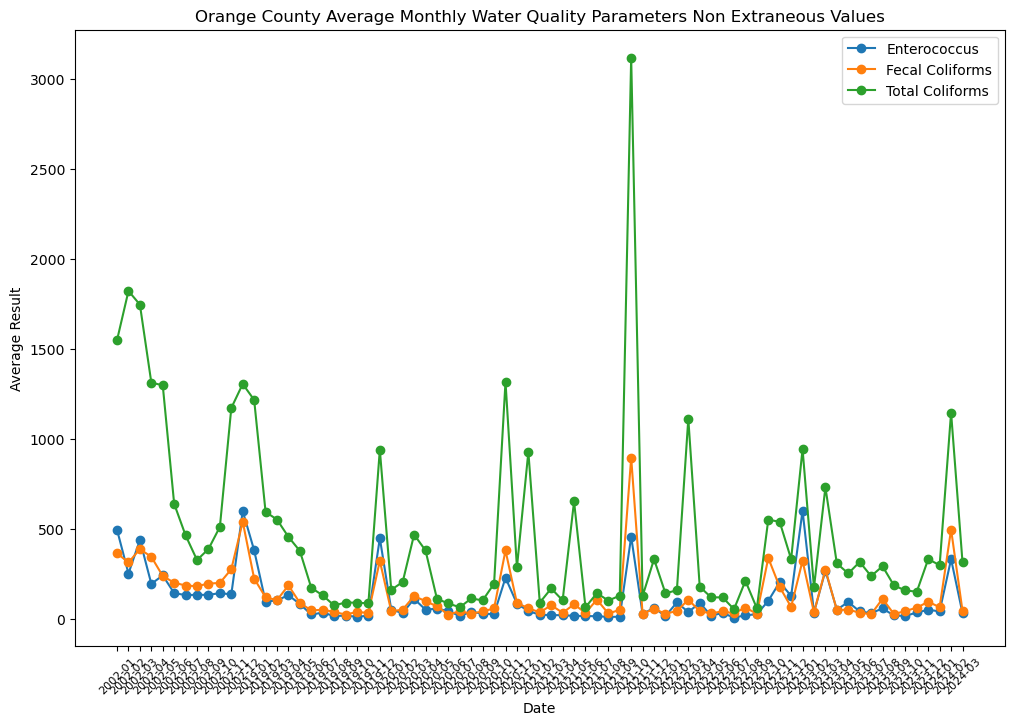

In [247]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming dfBeach is your DataFrame
dfBeach['SampleDate'] = pd.to_datetime(dfBeach['SampleDate'])

# Create a new DataFrame for filtered data without modifying the original DataFrame
df_graph = dfBeach[dfBeach['Result'] < 30000].copy()
df_graph = df_graph[df_graph['County'] == 'Orange']

# Calculate the average monthly result for each parameter
df_graph['Month'] = df_graph['SampleDate'].dt.to_period('M')
monthly_avg = df_graph.groupby(['Month', 'parameter'])['Result'].mean().unstack()

# Convert Period index to string
monthly_avg.index = monthly_avg.index.strftime('%Y-%m')

# Plot the data
plt.figure(figsize=(12, 8))
for column in monthly_avg.columns:
    plt.plot(monthly_avg.index, monthly_avg[column], marker='o', linestyle='-', label=column)

plt.xlabel('Date')
plt.ylabel('Average Result')
plt.title('Orange County Average Monthly Water Quality Parameters Non Extraneous Values')
plt.legend()
plt.xticks(rotation=45, fontsize=8)  # Set the font size for x-axis labels
plt.show()


#### Average Monthly San Diego

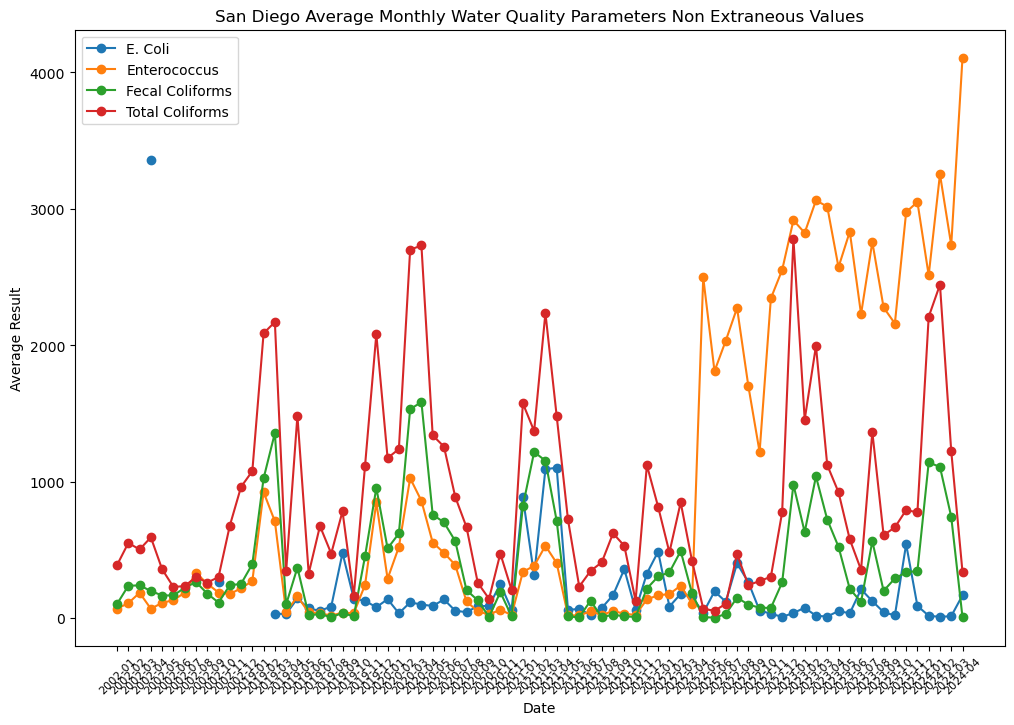

In [248]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming dfBeach is your DataFrame
dfBeach['SampleDate'] = pd.to_datetime(dfBeach['SampleDate'])

# Create a new DataFrame for filtered data without modifying the original DataFrame
df_sdgraph = dfBeach[dfBeach['Result'] < 30000].copy()
df_sdgraph = df_sdgraph[df_sdgraph['County'] == 'San Diego']

# Calculate the average monthly result for each parameter
df_sdgraph['Month'] = df_sdgraph['SampleDate'].dt.to_period('M')
monthly_avg = df_sdgraph.groupby(['Month', 'parameter'])['Result'].mean().unstack()

# Convert Period index to string
monthly_avg.index = monthly_avg.index.strftime('%Y-%m')

# Plot the data
plt.figure(figsize=(12, 8))
for column in monthly_avg.columns:
    plt.plot(monthly_avg.index, monthly_avg[column], marker='o', linestyle='-', label=column)

plt.xlabel('Date')
plt.ylabel('Average Result')
plt.title('San Diego Average Monthly Water Quality Parameters Non Extraneous Values')
plt.legend()
plt.xticks(rotation=45, fontsize=8)  # Set the font size for x-axis labels
plt.show()


# Interactable Graph of Beach Water Quality

In [249]:
import pandas as pd
import plotly.express as px

# Assuming dfBeach is your DataFrame
dfBeach['SampleDate'] = pd.to_datetime(dfBeach['SampleDate'])

# Filter the DataFrame for years greater than or equal to 2018 and parameter equal to 'Enterococcus'
df_filtered = dfBeach[(dfBeach['SampleDate'].dt.year >= 2018) & (dfBeach['parameter'] == 'Total Coliforms')]

# Group by beach and year, calculate the average
df_grouped = df_filtered.groupby(['Beach Name', df_filtered['SampleDate'].dt.year])['Result'].mean().reset_index()

# Create an interactive line plot using Plotly
fig = px.line(df_grouped, x='SampleDate', y='Result', color='Beach Name',
              labels={'Result': 'Average Total Coliforms per 100/mL'},
              title='Average Water Quality Parameter Over Time (2019-2024) for Total Coliforms by Beach Name')

# Update layout to add custom legend
fig.update_layout(
    legend=dict(
        title='Beach Name',
        itemsizing='constant'
    )
)

# Show the interactive plot
fig.show()


# Percentages

In [250]:
import pandas as pd

# Assuming dfBeach is your DataFrame
# Filter the DataFrame for San Diego County and the year 2023
df_filtered = dfBeach[(dfBeach['County'] == 'Orange') & 
                      (dfBeach['SampleDate'].dt.year == 2023) &
                      (dfBeach['parameter'] == 'Total Coliforms')]
print(df_filtered)
# Calculate the total number of 'Total Coliform' results
total_results = len(df_filtered)

# Calculate the number of 'Total Coliform' results over 1000
results_over_1000 = len(df_filtered[df_filtered['parameter'] == 'Total Coliforms'][df_filtered['Result'] >= 1000])

# Calculate the percentage of 'Total Coliform' results over 1000
percentage_over_1000 = (results_over_1000 / total_results) * 100
print(total_results)
print(results_over_1000)
print("Percentage of 'Total Coliform' results over 1000 within Orange County in 2023:", percentage_over_1000)


        id  Station_ID Station Name SampleDate SampleTime        parameter  \
72451   71          71           6S 2023-12-28    0:00:00  Total Coliforms   
72454   75          75           9N 2023-12-28    0:00:00  Total Coliforms   
72457   76          76           9S 2023-12-28    0:00:00  Total Coliforms   
72460   53          53          39S 2023-12-28    0:00:00  Total Coliforms   
72463   54          54           3N 2023-12-28    0:00:00  Total Coliforms   
...    ...         ...          ...        ...        ...              ...   
93989   54          54           3N 2023-01-03    0:00:00  Total Coliforms   
93992   70          70           6N 2023-01-03    0:00:00  Total Coliforms   
93995   75          75           9N 2023-01-03    0:00:00  Total Coliforms   
93998  660         660          S-1 2023-01-03    0:00:00  Total Coliforms   
94001  658         658          S-0 2023-01-03    0:00:00  Total Coliforms   

      qualifier  Result       unit            method     type  

In [251]:
import pandas as pd

# Assuming dfBeach is your DataFrame
# Filter the DataFrame for San Diego County and the year 2023
df_filtered = dfBeach[(dfBeach['County'] == 'San Diego') & 
                      (dfBeach['SampleDate'].dt.year == 2023) &
                      (dfBeach['parameter'] == 'Total Coliforms')]
print(df_filtered)
# Calculate the total number of 'Total Coliform' results
total_results = len(df_filtered)

# Calculate the number of 'Total Coliform' results over 1000
results_over_1000 = len(df_filtered[df_filtered['parameter'] == 'Total Coliforms'][df_filtered['Result'] >= 1000])

# Calculate the percentage of 'Total Coliform' results over 1000
percentage_over_1000 = (results_over_1000 / total_results) * 100
print(total_results)
print(results_over_1000)
print("Percentage of 'Total Coliform' results over 1000 within San Diego in 2023:", percentage_over_1000)


        id  Station_ID Station Name SampleDate SampleTime        parameter  \
10     330         330       EH-070 2023-12-28    8:22:00  Total Coliforms   
31     638         638       PL-040 2023-12-27    9:42:00  Total Coliforms   
34     639         639       PL-050 2023-12-27    9:31:00  Total Coliforms   
37     641         641       PL-070 2023-12-27    8:56:00  Total Coliforms   
40     643         643       PL-090 2023-12-27    8:31:00  Total Coliforms   
...    ...         ...          ...        ...        ...              ...   
12126  706         706       SE-040 2023-01-02    8:47:00  Total Coliforms   
12129  707         707       SE-050 2023-01-02    8:29:00  Total Coliforms   
12132  709         709       SE-070 2023-01-02    8:13:00  Total Coliforms   
12137  703         703       SE-010 2023-01-02    9:28:00  Total Coliforms   
12140  704         704       SE-020 2023-01-02    9:15:00  Total Coliforms   

      qualifier  Result       unit       method     type     Co

In [252]:
import pandas as pd

# Assuming dfBeach is your DataFrame
# Filter the DataFrame for San Diego County and the year 2023
df_filtered = dfBeach[(dfBeach['County'] == 'San Diego') & 
                      (dfBeach['SampleDate'].dt.year == 2023) &
                      (dfBeach['parameter'] == 'Enterococcus')]
print(df_filtered)
# Calculate the total number of 'Total Coliform' results
total_results = len(df_filtered)

# Calculate the number of 'Total Coliform' results over 1000
results_over_1000 = len(df_filtered[df_filtered['parameter'] == 'Enterococcus'][df_filtered['Result'] >= 35])

# Calculate the percentage of 'Total Coliform' results over 1000
percentage_over_1000 = (results_over_1000 / total_results) * 100
print(total_results)
print(results_over_1000)
print("Percentage of 'Entroccocus' results over 35 within San Diego in 2023:", percentage_over_1000)


         id  Station_ID Station Name SampleDate SampleTime     parameter  \
0       460         460       IB-060 2023-12-29    6:42:00  Enterococcus   
1      1037        1037       IB-068 2023-12-29    8:13:00  Enterococcus   
2      1038        1038       IB-079 2023-12-29    7:39:00  Enterococcus   
3       322         322       EH-030 2023-12-29    6:30:00  Enterococcus   
4       459         459       IB-050 2023-12-29    6:15:00  Enterococcus   
...     ...         ...          ...        ...        ...           ...   
12135   325         325       EH-050 2023-01-02    6:26:00  Enterococcus   
12136   328         328       EH-060 2023-01-02    6:37:00  Enterococcus   
12139   703         703       SE-010 2023-01-02    9:28:00  Enterococcus   
12142   704         704       SE-020 2023-01-02    9:15:00  Enterococcus   
12143  1038        1038       IB-079 2023-01-02    6:19:00  Enterococcus   

      qualifier   Result          unit      method     type     County  \
0       #ERRO